In [1]:
import numpy as np
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=17)

# Dishonest Answering Machine

In [2]:
EMPTYSET = frozenset(set())

In [3]:
def food_dynamics(food_presence):
    if rng.random() < p_food:
        return min(food_presence + 1, 2)
    return food_presence
    
def hunger_dynamics(hunger, time_since_eat):
    return hunger + 1/(np.power(2, time_since_eat))
#     return hunger + h_decrease/2

def question_dynamics(q):
    if rng.random() < p_q:
        return 1
    return 0
    
def utter_dynamics(u):
    return EMPTYSET  

def eating_dynamics(e):
    if e:
        return EMPTYSET
    elif e == EMPTYSET:
        return 0
    return e

dynamics = dict(f=food_dynamics, q=question_dynamics, h=hunger_dynamics, u=utter_dynamics, e=eating_dynamics)


def plot_food(axis, states, mnings):
    times = list(range(len(states['post'])))
    for t in times:
        if t:
            tpre = t - pre_post_offset
            tpost = t + pre_post_offset
            axis.plot(tpre, states['pre'][t]['f'], 'o', color=meaning_colors[mnings[t]])
            axis.plot(tpost, states['post'][t]['f'], '*', color='purple')
        else:
            axis.plot(t, states['post'][t]['f'], '*', color='purple')
    axis.set_ylim([0 - margin, 2 + margin])
    axis.set_ylabel('f')
    axis.set_xticks(time_steps)
    axis.grid()
    
def plot_question_or_hunger(axis, states, mnings, key):
    """works for question or hunger"""
    times = list(range(len(states['post'])))
    for t in times:
        if t:
            tpre = t - pre_post_offset
            tpost = t + pre_post_offset
            axis.plot(tpre, states['pre'][t][key], 'o', color=meaning_colors[mnings[t]])
            axis.plot(tpost, states['post'][t][key], '*', color='purple')
        else:
            axis.plot(t, states['post'][t][key], '*', color='purple')
    axis.set_ylabel(key)
    axis.set_xticks(time_steps)
    if key == 'q':
        axis.set_ylim([0 - margin, 1 + margin])
        axis.grid()
    elif key == 'h':
        axis.axhline(h_threshold)
        
def plot_utterance_or_eating(axis, states, mnings, key):
    """works for utterance or eating"""
    m = {EMPTYSET: 0, 'yes':2, 'no': 1, 0: 1, 1: 2}
    for t in time_steps:
        if t:
            tpre = t - pre_post_offset
            tpost = t + pre_post_offset
            axis.plot(tpre, m[states['pre'][t][key]], 'o', color=meaning_colors[mnings[t]])
            axis.plot(tpost, m[states['post'][t][key]], '*', color='purple')
        else:
            axis.plot(t, m[states['pre'][t][key]], '*', color='purple')
    axis.set_ylabel(key)
    axis.set_ylim([0 - margin, 2 + margin])
    axis.set_yticks([0, 1, 2])
    if key == 'u':
        axis.set_yticklabels(['silent', 'no', 'yes'])
    else:
        axis.set_yticklabels(['blocked', 'inactive', 'eating'])
    axis.set_xticks(time_steps)
    axis.grid()
    
plotter = dict(
    f=plot_food, 
    q=plot_question_or_hunger, 
    h=plot_question_or_hunger,
    u=plot_utterance_or_eating,
    e=plot_utterance_or_eating
)

In [4]:
def eat(sstate):
    if sstate['f'] > 0 and sstate['h'] and sstate['u'] == EMPTYSET and sstate['e'] in {0, 1}:
        new = sstate.copy()
        new['u'] = EMPTYSET
        new['e'] = 1
        if sstate['f'] > 0:
            new['f'] -= 1
            new['h'] = max(sstate['h'] - h_decrease, 0)
        return new
    else:
        raise(ValueError('not triggered'))
    
def utter(sstate):
    new = sstate.copy()
    if sstate['h'] <= h_threshold:  # not hungry
        # there is food
        if sstate['f'] > 0 and sstate['q'] and sstate['e'] in {EMPTYSET, 0}:
            new['u'] = 'yes'
            new['e'] = 0
            return new
        # there is no food
        elif sstate['f'] == 0 and sstate['q'] and sstate['e'] in {EMPTYSET, 0}:
            new['u'] = 'no'
            new['e'] = 0
            return new
        else:
            raise(ValueError('not triggered'))
    else:  # hungry
        if sstate['q'] and sstate['e'] in {EMPTYSET, 0}:
            new['u'] = 'no'
            new['e'] = 0
            return new
        else:
            raise(ValueError('not triggered'))

In [5]:
for iii in range(10000):
    rng = np.random.default_rng(iii)
    start_time = 0
    time_steps = [start_time]
    time_horizon = 10
    pre_post_offset = .08
    last_eat = 0  # counter timesteps since last eaten
    p_q = .7  # prob ask question
    p_food = .7  # prob food replenishes
    h_threshold = .55  # hunger threshold
    h_decrease = 8/10  # hunger decrement step
    start_state = dict(f=0, q=0, h=0, u=EMPTYSET, e=0)
#     pprint(start_state)
#     pprint(start_state.copy())
    pre_action_state_logger = {start_time: start_state}
    post_action_state_logger = {start_time: start_state}
    meanings = ['neutral']
    meaning_colors = {'neutral': 'k', 'eat': 'red', 'yes': 'green', 'no': 'blue'}
    margin = .2

    while start_time < time_horizon:    
        assert start_state['h'] >= 0
        start_time += 1
        time_steps.append(start_time)
        last_eat += 1
        new_state = start_state.copy()

        # apply independent dynamics
        for k, s in start_state.items():
            if k == 'h':
                new_state[k] = dynamics[k](s, last_eat)
            else:
                new_state[k] = dynamics[k](s)
            if new_state[k] is None:
                print(f'pb at time {start_time}')
                raise(ValueError(f'{k}'))

        pre_action_state_logger[start_time] = new_state

        # act
        try:  # first try to eat (priority action)
            new_state = eat(new_state)
            last_eat = 0
            meanings.append('eat')
        except ValueError:
            try:  # if eating fails, try to utter
                new_state = utter(new_state)
                meanings.append(new_state['u'])
            except ValueError:
                meanings.append('neutral')

        post_action_state_logger[start_time] = new_state
        start_state = new_state
    # print(f'total number of timesteps {start_time + 1}')
    assert start_time+1 == len(post_action_state_logger)
    assert start_time+1 == len(pre_action_state_logger)
    assert start_time+1 == len(meanings)
    assert start_time+1 == len(time_steps)

    lies = []
    for t, m in zip(time_steps, meanings):
        if pre_action_state_logger[t]['f'] and m == 'no':
            lies.append(True)
        else:
            lies.append(False)

    if any(lies) and 'yes' in meanings and 'no' in meanings:
        break
any(lies) and 'yes' in meanings and 'no' in meanings

True

In [6]:
print(f'working seed was {iii}')

working seed was 13


{'eat': 'red', 'neutral': 'k', 'no': 'blue', 'yes': 'green'}


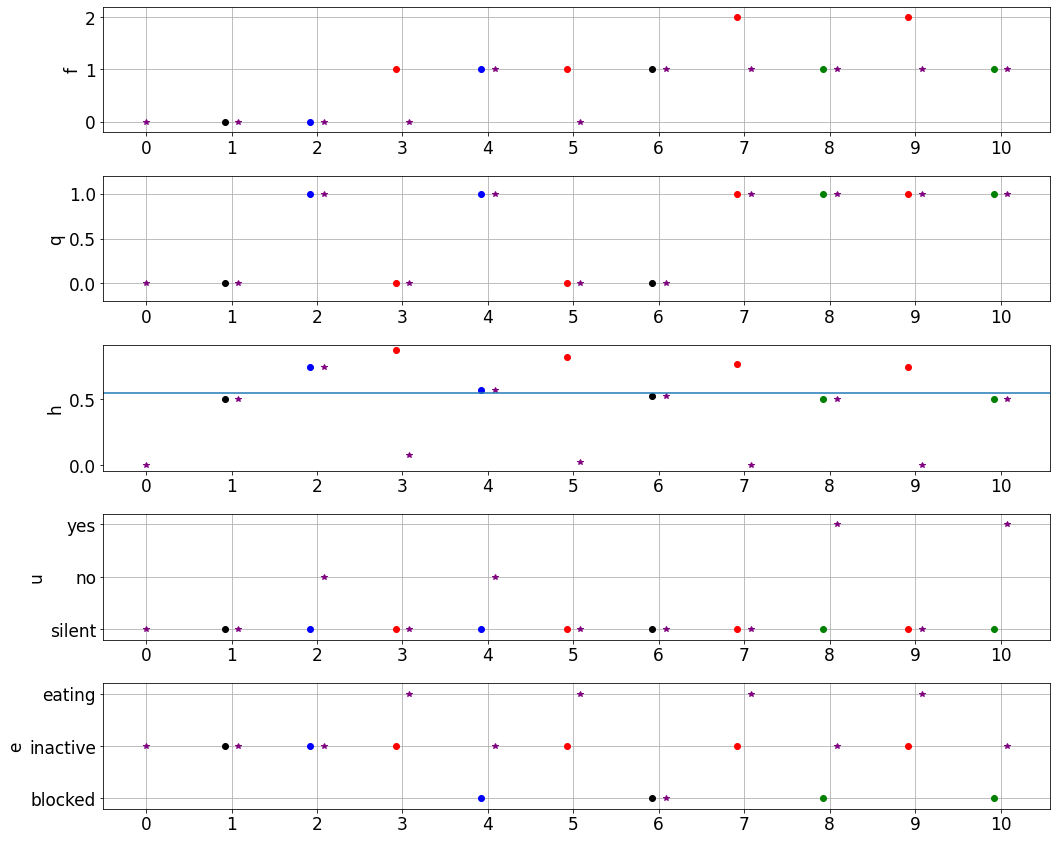

In [7]:
pprint(meaning_colors)
all_states = {'pre': pre_action_state_logger, 'post': post_action_state_logger}
fig, axes = plt.subplots(len(start_state), 1, figsize=(15, 12))
plotter['f'](axes[0], all_states, meanings)
plotter['q'](axes[1], all_states, meanings, 'q')
plotter['h'](axes[2], all_states, meanings, 'h')
plotter['u'](axes[3], all_states, meanings, 'u')
plotter['e'](axes[4], all_states, meanings, 'e')
fig.tight_layout()